In [0]:
* Author: HZQ
* Last modified: 2019/3/9

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [5]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os

os.chdir("driver/Colab Notebooks/Santander_Cus_ Trans_kaggle/")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
data	  LICENSE  README.md	     submit    utils
download  model    requirements.txt  timeline


In [0]:
!pip install catboost

In [2]:
import gc
import os
import string
import time
import random
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

from scipy.stats import norm  
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold

from catboost import Pool, CatBoostClassifier
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
color = sns.color_palette()
%matplotlib inline
py.init_notebook_mode(connected=True)

In [0]:
train_df = pd.read_csv("./data/data_raw/train/train.csv")
test_df = pd.read_csv("./data/data_raw/test/test.csv")

In [8]:
# Taking a look at how many rows and columns the train dataset contains
rows1 = train_df.shape[0]; rows2 = test_df.shape[0]; 
columns1 = train_df.shape[1]; columns2 = test_df.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows1, columns1))
print("The test dataset contains {0} rows and {1} columns".format(rows2, columns2))

The train dataset contains 200000 rows and 202 columns
The test dataset contains 200000 rows and 201 columns


In [9]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [13]:
data = [go.Bar(
            x = train_df["target"].value_counts().index.values,
            y = train_df["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [14]:
#https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-nn-approach
def mis_value_graph(data):  
    data = [
    go.Bar(
        x = data.columns,
        y = data.isnull().sum(),
        name = 'Counts of Missing value',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
    layout= go.Layout(
        title= '"Total Missing Value By Column"',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='skin')
    
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

mis_value_graph(train_df)

In [15]:
#https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-nn-approach
def mis_value_graph(data):  
    data = [
    go.Bar(
        x = data.columns,
        y = data.isnull().sum(),
        name = 'Counts of Missing value',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
    layout= go.Layout(
        title= '"Total Missing Value By Column"',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='skin')
    
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

mis_value_graph(test_df)

In [16]:
train_int = train_df.copy()
del train_int['ID_code']
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x= train_int.columns.values,
        y= train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        #text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# https://www.kaggle.com/fayzur/customer-transaction-prediction-strong-baseline
# Thanks fayzur. Nice Parameter 
param = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }


In [0]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [22]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904023	valid_1's auc: 0.885467
[2000]	training's auc: 0.920194	valid_1's auc: 0.894343
[3000]	training's auc: 0.93036	valid_1's auc: 0.898123
[4000]	training's auc: 0.937844	valid_1's auc: 0.899242
Early stopping, best iteration is:
[4536]	training's auc: 0.941474	valid_1's auc: 0.899582
fold n°1
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.90429	valid_1's auc: 0.881143
[2000]	training's auc: 0.920373	valid_1's auc: 0.890459
[3000]	training's auc: 0.930447	valid_1's auc: 0.894494
[4000]	training's auc: 0.937946	valid_1's auc: 0.896397
[5000]	training's auc: 0.944554	valid_1's auc: 0.89699
Early stopping, best iteration is:
[5103]	training's auc: 0.945216	valid_1's auc: 0.89702
fold n°2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904008	valid_1's auc: 0.886731
[2000]	training's auc: 0.919919	valid_1's auc:

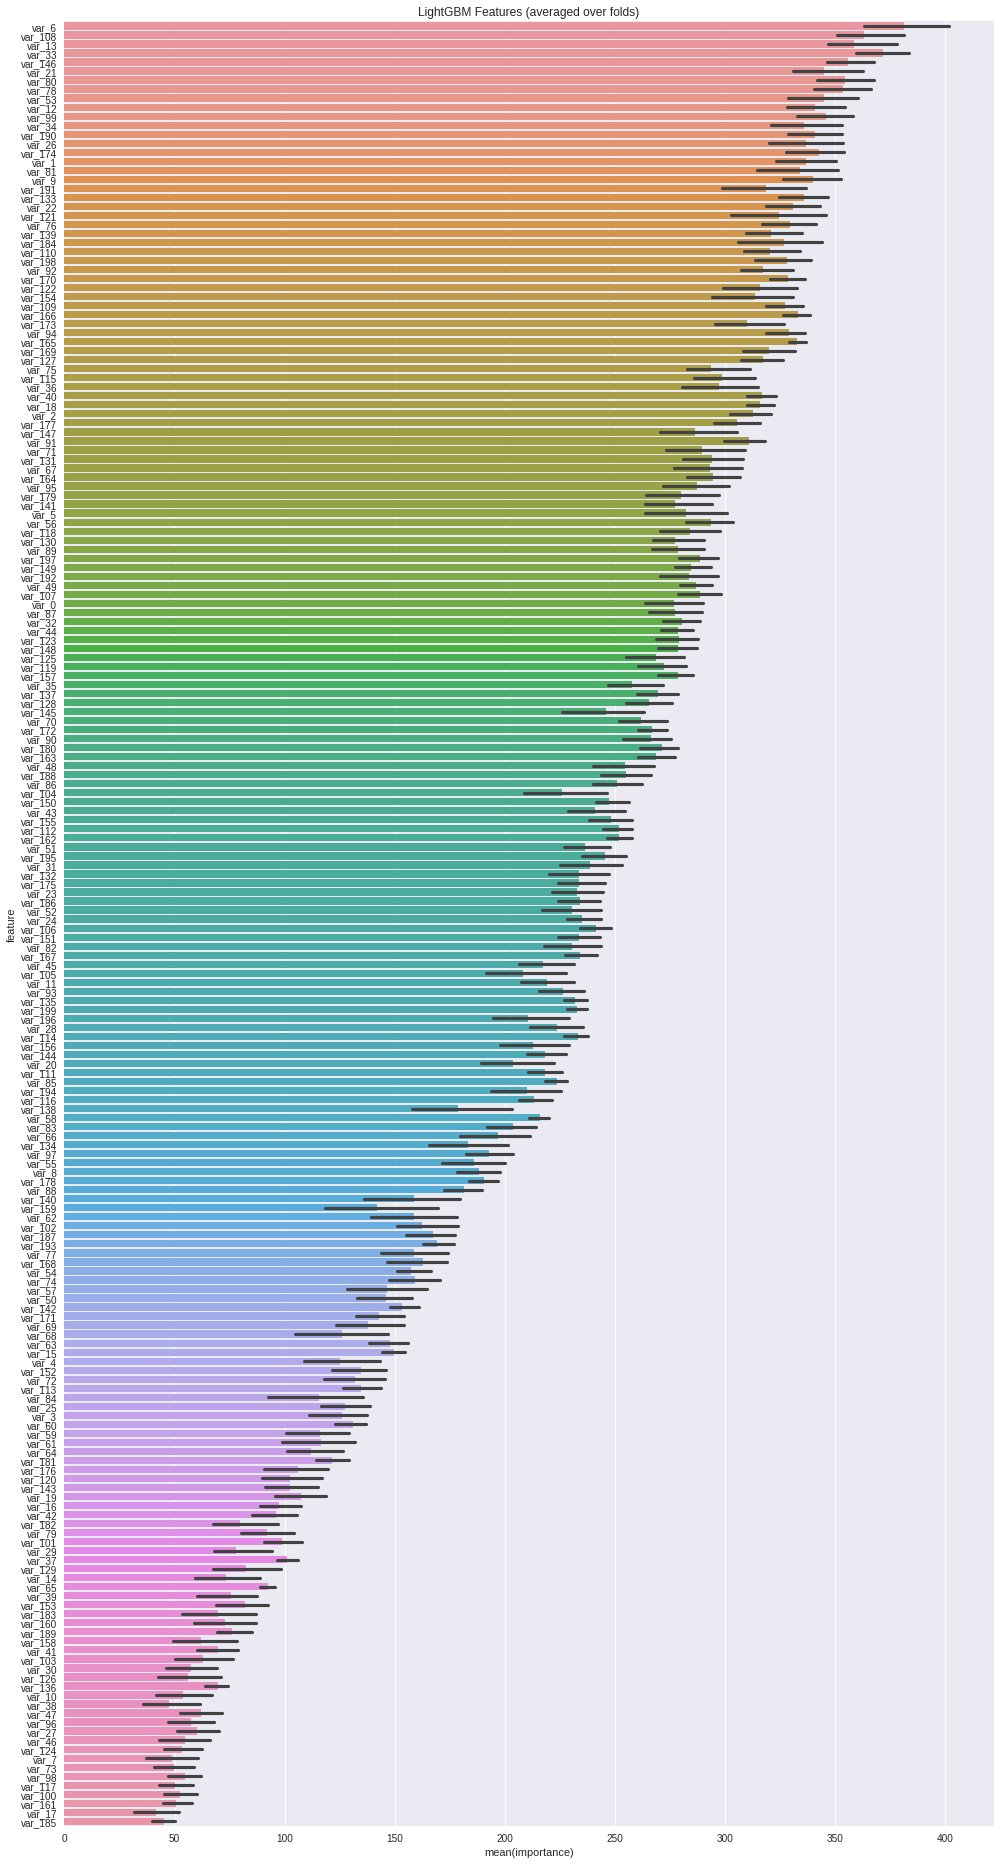

In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
##submission
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("lgb_submission.csv", index=False)

In [28]:
## Catboost : https://www.kaggle.com/wakamezake/starter-code-catboost-baseline


model = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC")
kf = KFold(n_splits=5, random_state=42, shuffle=True)

y_valid_pred = 0 * target
y_test_pred = 0

for idx, (train_index, valid_index) in enumerate(kf.split(train_df)):
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df[features].iloc[train_index,:], train_df[features].iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)
    _valid = Pool(X_valid, label=y_valid)
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  auc = ", roc_auc_score(y_valid, pred) )
    y_valid_pred.iloc[valid_index] = pred
    y_test_pred += fit_model.predict_proba(test_df[features])[:,1]
y_test_pred /= 5


Fold  0
Learning rate set to 0.132949
0:	test: 0.5315318	best: 0.5315318 (0)	total: 346ms	remaining: 5m 45s
200:	test: 0.8831111	best: 0.8831111 (200)	total: 54.5s	remaining: 3m 36s
400:	test: 0.8924405	best: 0.8924405 (400)	total: 1m 50s	remaining: 2m 45s
600:	test: 0.8951229	best: 0.8951415 (598)	total: 2m 46s	remaining: 1m 50s
800:	test: 0.8953375	best: 0.8954127 (786)	total: 3m 40s	remaining: 54.9s
999:	test: 0.8955113	best: 0.8955990 (924)	total: 4m 34s	remaining: 0us

bestTest = 0.8955990231
bestIteration = 924

Shrink model to first 925 iterations.
  auc =  0.8955990230803251

Fold  1
Learning rate set to 0.132949
0:	test: 0.5274413	best: 0.5274413 (0)	total: 309ms	remaining: 5m 8s
200:	test: 0.8836085	best: 0.8836085 (200)	total: 55.3s	remaining: 3m 39s
400:	test: 0.8941822	best: 0.8942216 (399)	total: 1m 52s	remaining: 2m 47s
600:	test: 0.8971854	best: 0.8971897 (599)	total: 2m 48s	remaining: 1m 51s
800:	test: 0.8975168	best: 0.8977881 (710)	total: 3m 42s	remaining: 55.4s
999

In [0]:
##submission
sub_df1 = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df1["target"] = y_test_pred
sub_df1.to_csv("cat_submission.csv", index=False)

In [30]:
corr_df = pd.merge(sub_df,sub_df1,how='left',on='ID_code')
corr_df.corr()

,target_x,target_y
target_x,1.000000,0.863635
target_y,0.863635,1.000000


In [0]:
#submission
sub_df2 = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df2["target"] = 0.5*sub_df["target"] + 0.5*sub_df1["target"]
sub_df2.to_csv("lgb_cat_submission.csv", index=False)